In [3]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='talk', style='ticks',
        color_codes=True, rc={'legend.frameon': False})

%matplotlib inline

In [4]:
import tensorflow as tf
import tensorflow_addons as tfa

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)

In [5]:
import nfp
nfp.__version__

'0.1.4'

In [6]:
bde = pd.read_csv('20200614_rdf_new_elements.csv.gz', index_col=0)

train = bde[bde.set == 'train'].molecule.unique()
valid = bde[bde.set == 'valid'].molecule.unique()
test = bde[bde.set == 'test'].molecule.unique()

from preprocess_inputs import preprocessor
preprocessor.from_json('tfrecords/preprocessor.json')

In [191]:
len(bde)

816311

,rid,molecule,bond_index,bond_type,fragment1,fragment2,bde,bdfe,set
0,1,NCCCC(=O)O,0,C-N,[CH2]CCC(=O)O,[NH2],87.599001,73.447418,train
1,2,NCCCC(=O)O,1,C-C,[CH2]CC(=O)O,[CH2]N,82.344241,67.277122,train
2,3,NCCCC(=O)O,2,C-C,[CH2]C(=O)O,[CH2]CN,86.313863,71.784520,train
3,4,NCCCC(=O)O,3,C-C,O=[C]O,[CH2]CCN,95.898435,80.873360,train
4,5,NCCCC(=O)O,5,C-O,NCCC[C]=O,[OH],111.411713,98.588566,train
...,...,...,...,...,...,...,...,...,...
816303,1933966,O=[P@@H](O)CC1=CCNCC1,14,C-H,[H],O=[P@@H](O)CC1=[C]CNCC1,109.699241,101.168256,train
816304,1933967,O=[P@@H](O)CC1=CCNCC1,15,C-H,[H],O=[P@@H](O)CC1=C[CH]NCC1,73.445536,65.535157,train
816306,1933969,O=[P@@H](O)CC1=CCNCC1,17,H-N,[H],O=[P@@H](O)CC1=CC[N]CC1,93.934332,85.235175,train
816307,1933970,O=[P@@H](O)CC1=CCNCC1,18,C-H,[H],O=[P@@H](O)CC1=CCN[CH]C1,90.750979,82.135908,train


In [194]:
bde.drop_duplicates(subset=['molecule', 'fragment1', 'fragment2']).bond_type.value_counts()

C-H     255962
C-C     116227
C-N      38457
C-O      38004
H-N      28421
H-O      16177
C-S       9260
C-F       5674
C-Cl      4074
N-O       1925
N-N       1870
N-S       1345
H-S        761
Br-C       638
O-P        345
O-O        303
C-P        277
O-S        209
H-P         59
N-P         27
Cl-N        12
F-N          2
Br-N         1
Name: bond_type, dtype: int64

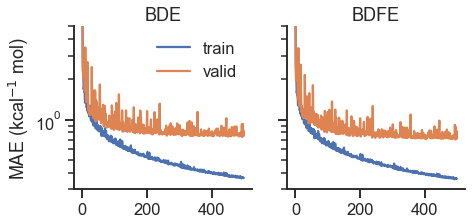

In [22]:
log = pd.read_csv('20201010_model/log.csv').set_index('epoch')

fig, axs = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, figsize=(7,3))

axs[0].set_title('BDE')
axs[0].plot(log['bde_loss'], label='train')
axs[0].plot(log['val_bde_loss'], label='valid')
axs[0].legend(loc='upper right')

axs[1].set_title('BDFE')
axs[1].plot(log['bdfe_loss'])
axs[1].plot(log['val_bdfe_loss'])

axs[0].set_ylabel('MAE (kcal${}^{-1}$ mol)')

plt.gca().set_yscale('log')
plt.ylim([.3, 5.])
sns.despine()

In [9]:
model = tf.keras.models.load_model('20201010_model/best_model.hdf5', custom_objects=nfp.custom_objects)

In [187]:
tf.__version__

'2.3.1'

In [25]:
import itertools

In [49]:
test_dataset = tf.data.Dataset.from_generator(
    lambda: (preprocessor.construct_feature_matrices(smiles, train=False) for smiles in test),
    output_types=preprocessor.output_types, output_shapes=preprocessor.output_shapes)\
    .padded_batch(batch_size=128, padded_shapes=preprocessor.padded_shapes(max_bonds=64),
                  padding_values=preprocessor.padding_values)

predicted_bdes, predicted_bdfes = model.predict(test_dataset, verbose=True)

8/8 [==============================] - 1s 117ms/step


In [89]:
pred_bdes = pd.DataFrame(predicted_bdes.squeeze(), index=test).reset_index().melt(id_vars='index').rename(
    columns={'index': 'molecule', 'variable': 'bond_index', 'value': 'pred_bde'})
pred_bdes['pred_bdfe'] = pd.DataFrame(predicted_bdfes.squeeze(), index=test).melt()['value']

merged = bde.merge(pred_bdes, on=['molecule', 'bond_index'])

Text(0.95, 0.05, 'MAE: 0.654 kcal/mol')

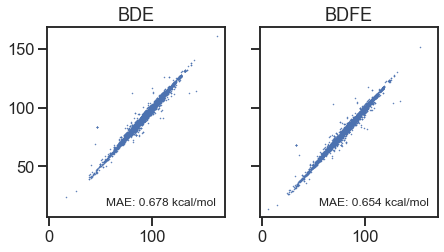

In [93]:
fig, axs = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, figsize=(7,3.5))

axs[0].plot(merged['bde'], merged['pred_bde'], '.', color='b', ms=1)
axs[1].plot(merged['bdfe'], merged['pred_bdfe'], '.', color='b', ms=1)
axs[0].set_title('BDE')
axs[1].set_title('BDFE')
axs[0].text(.95, .05, f"MAE: {(merged['bde'] - merged['pred_bde']).abs().mean():.3f} kcal/mol", ha='right', va='bottom', transform=axs[0].transAxes, fontsize=12)
axs[1].text(.95, .05, f"MAE: {(merged['bdfe'] - merged['pred_bdfe']).abs().mean():.3f} kcal/mol", ha='right', va='bottom', transform=axs[1].transAxes, fontsize=12)

In [207]:
merged['fe_diff'] = merged['pred_bde'] - merged['pred_bdfe']

In [212]:
high_bond_counts = merged.bond_type.value_counts()

,molecule,bond_index,bond_type,fragment1,fragment2,bde,bdfe,set,pred_bde,pred_bdfe,bde_err,bdfe_err,fe_diff
0,C#CCc1ccccc1,2,C-C,C#C[CH2],[c]1ccccc1,90.338078,77.573918,test,90.950226,78.054932,0.612148,0.481014,12.895294
1,CC/C=N\NCCCC,7,C-C,[CH2]CCN/N=C\CC,[CH3],87.684343,74.718752,test,88.848526,75.405220,1.164183,0.686468,13.443306
2,CC(C)(C)NC(C)(C)C,17,H-N,[H],CC(C)(C)[N]C(C)(C)C,95.639902,86.477643,test,92.455986,83.978569,3.183916,2.499074,8.477417
3,CC1(C)OC[C@](C)(O)OO1,16,C-H,[H],CC1(C)O[CH][C@](C)(O)OO1,95.228256,86.392302,test,96.098557,87.066963,0.870301,0.674662,9.031593
4,CC1(C)OC[C@](C)(O)OO1,17,C-H,[H],CC1(C)O[CH][C@](C)(O)OO1,95.228256,86.392302,test,96.098557,87.066963,0.870301,0.674662,9.031593
...,...,...,...,...,...,...,...,...,...,...,...,...,...
13215,CC(C)(C)CCNCCO,4,C-C,[CH2]NCCO,[CH2]C(C)(C)C,81.052200,66.523484,test,80.617950,66.521744,0.434250,0.001740,14.096207
13216,CNS(=O)(=O)N[C@H](C)CN,5,C-N,C[CH]CN,CNS([NH])(=O)=O,94.612042,78.992715,test,93.999016,78.688499,0.613026,0.304216,15.310516
13218,CC(C)(C)CC(=O)CO,4,C-C,O=[C]CO,[CH2]C(C)(C)C,87.241949,71.532261,test,86.765274,72.054039,0.476675,0.521778,14.711235
13219,C=C(Cl)CS[C@@H]1CCOC1,2,C-C,C=[C]Cl,[CH2]S[C@@H]1CCOC1,91.402961,78.354539,test,91.024506,77.384636,0.378455,0.969903,13.639870


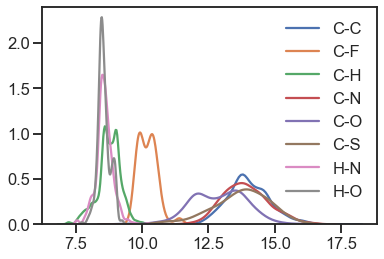

In [215]:
for name, df in merged[merged.bond_type.isin(high_bond_counts[high_bond_counts > 100].index)].groupby('bond_type'):
    sns.kdeplot(df['fe_diff'], label=name)

Text(0.5, 0, 'Predicted BDE - BDFE')

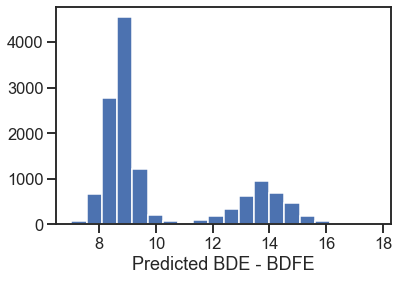

In [94]:
plt.hist(merged['pred_bde'] - merged['pred_bdfe'], bins=20)
plt.xlabel('Predicted BDE - BDFE')

In [102]:
merged['bde_err'] = (merged['bde'] - merged['pred_bde']).abs()
merged['bdfe_err'] = (merged['bdfe'] - merged['pred_bdfe']).abs()

Text(0, 0.5, 'BDE MAE')

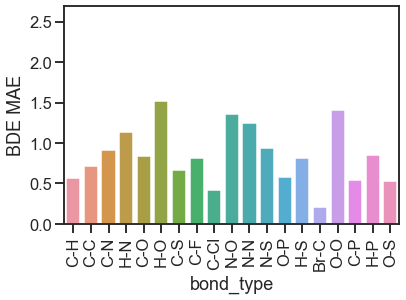

In [150]:
sns.barplot(y='bde_err', x='bond_type', data=merged, errwidth=0,
            order=merged.bond_type.value_counts().index)
_ = plt.setp(plt.gca().get_xticklabels(), rotation=90)
plt.gca().set_ylabel('BDE MAE')

Text(0, 0.5, 'BDFE MAE')

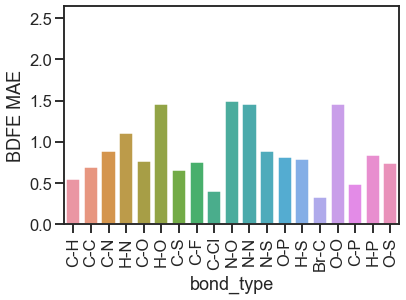

In [149]:
sns.barplot(y='bdfe_err', x='bond_type', data=merged, errwidth=0,
            order=merged.bond_type.value_counts().index)
_ = plt.setp(plt.gca().get_xticklabels(), rotation=90)
plt.gca().set_ylabel('BDFE MAE')

In [120]:
from tqdm import tqdm
tqdm.pandas()

from rdkit import Chem
from collections import Counter
def get_elements(smiles):
    mol = Chem.MolFromSmiles(smiles)
    elems = Counter((atom.GetSymbol() for atom in Chem.AddHs(mol).GetAtoms()))
    return pd.Series(elems)
    
elems = pd.Series(test).progress_apply(get_elements).fillna(0).astype(int)
elems.index = test

/projects/rlmolecule/pstjohn/envs/tf2_gpu/lib/python3.7/site-packages/tqdm/std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
100%|██████████| 1000/1000 [00:03<00:00, 253.61it/s]


In [196]:
elems_all = pd.Series(bde.molecule.unique()).progress_apply(get_elements).fillna(0).astype(int)

100%|██████████| 63331/63331 [00:48<00:00, 1303.96it/s]


Text(0.5, 0, 'Number of Heavy Atoms')

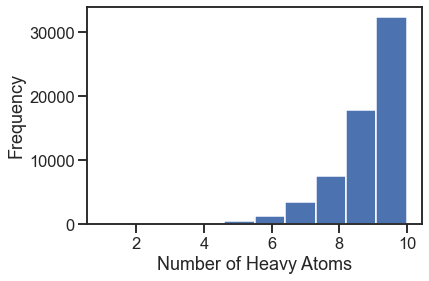

In [201]:
elems_all.drop('H', 1).sum(1).plot.hist()
plt.xlabel('Number of Heavy Atoms')

In [205]:
elems_all.drop('H', 1).sum(0).drop('C')

N     68824
O     77567
F      8747
S     13033
Cl     4703
Br      697
P       385
dtype: int64

In [132]:
melted_elems = (elems.drop(['C', 'H'], 1) > 0).reset_index().melt(id_vars='index')

In [139]:
bde_by_elem = merged.merge(melted_elems[melted_elems.value].drop('value', 1), left_on='molecule', right_on='index')

Text(0, 0.5, 'BDE MAE')

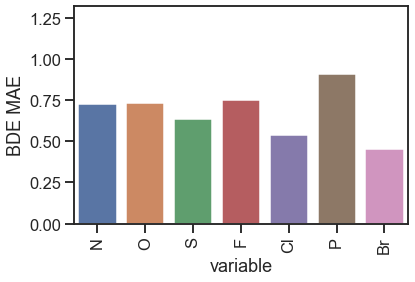

In [153]:
sns.barplot(y='bde_err', x='variable', data=bde_by_elem, errwidth=0)
_ = plt.setp(plt.gca().get_xticklabels(), rotation=90)
plt.gca().set_ylabel('BDE MAE')
# plt.ylim([0, 2])

In [119]:
elems.columns[2:]

Index(['N', 'O', 'S', 'F', 'Cl', 'P', 'Br'], dtype='object')

In [154]:
all_mols = bde.molecule.unique()

bde_dataset = tf.data.Dataset.from_generator(
    lambda: (preprocessor.construct_feature_matrices(smiles, train=False) for smiles in all_mols),
    output_types=preprocessor.output_types,
    output_shapes=preprocessor.output_shapes)\
    .padded_batch(batch_size=128, padded_shapes=preprocessor.padded_shapes(max_bonds=64),  # explicit padding required for consistent output shape
                  padding_values=preprocessor.padding_values)

In [165]:
model.layers[17].output

<tf.Tensor 'reduce/Reshape:0' shape=(None, None, 128) dtype=float32>

In [167]:
embedding_model = tf.keras.Model(model.inputs, [model.layers[17].output])
embeddings = embedding_model.predict(bde_dataset, verbose=True)

495/495 [==============================] - 67s 135ms/step


In [168]:
embeddings.shape

(63331, 64, 128)

In [172]:
bond_indices = np.concatenate([np.arange(32) for _ in all_mols])
mols = np.concatenate([np.array([mol] * 32) for mol in all_mols])

index_df = pd.DataFrame(mols, columns=['molecule'])
index_df['bond_index'] = bond_indices

embed_df = pd.DataFrame(embeddings[:, :32, :].reshape((-1, 128)))
embed_df = embed_df.join(index_df).set_index(['molecule', 'bond_index'])

In [173]:
bde = bde.sort_values('rid').reset_index()
embed_df = embed_df.reindex(bde[['molecule', 'bond_index']])

In [174]:
bde[(bde.molecule == 'CCc1cc(O)cc(O)c1') & (bde.bond_index == 16)]

,rid,molecule,bond_index,bond_type,fragment1,fragment2,bde,bdfe,set
89329,105390,CCc1cc(O)cc(O)c1,16,H-O,[H],CCc1cc([O])cc(O)c1,88.375858,80.088974,train


In [175]:
embed_df.iloc[89329]

0      -0.351219
1     -14.942307
2      14.119844
3       8.317989
4     -12.683212
         ...    
123   -14.818624
124    -0.285941
125     0.383272
126     0.276456
127    -0.100360
Name: (CCc1cc(O)cc(O)c1, 16), Length: 128, dtype: float32

In [176]:
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

pipe = Pipeline(steps=(
    ('PCA', PCA(n_components=10)),
    ('NearestNeighbors', NearestNeighbors(n_neighbors=10))
))

pipe.fit(embed_df.values)

Pipeline(steps=[('PCA', PCA(n_components=10)),
                ('NearestNeighbors', NearestNeighbors(n_neighbors=10))])

In [177]:
test_bond_embeddings = embed_df[embed_df.index.isin(test, level=0)].values

In [178]:
def pipe_kneighbors(pipe, X):
    Xt = pipe.steps[0][-1].transform(X)
    return pipe.steps[-1][-1].kneighbors(Xt)

distances, indices = pipe_kneighbors(pipe, test_bond_embeddings)

In [179]:
indices

array([[   592, 695965, 119801, ..., 490650, 462366, 402101],
       [   593, 526600, 561922, ..., 334205,  19864, 176054],
       [   594, 170564, 338923, ..., 143900, 143899, 143896],
       ...,
       [816061, 816062, 667157, ..., 633923, 787665, 607673],
       [816061, 816062, 667157, ..., 633923, 787665, 607673],
       [816060, 816063, 252845, ..., 243174, 185745, 182581]])

In [180]:
distances[:, :5]

array([[1.94738355e-04, 3.66760921e-01, 3.82006129e-01, 3.82007565e-01,
        3.86882073e-01],
       [7.26893590e-04, 3.79274937e-01, 5.27934162e-01, 5.36068051e-01,
        5.36069280e-01],
       [6.24197562e-04, 4.02308841e-01, 4.72006672e-01, 5.25659578e-01,
        5.39984422e-01],
       ...,
       [3.01739661e-04, 3.03836655e-04, 2.18959130e-02, 2.25974509e-02,
        3.40245008e-02],
       [3.02345325e-04, 3.04413791e-04, 2.18957073e-02, 2.25987702e-02,
        3.40243357e-02],
       [3.09884525e-04, 3.10153918e-04, 9.98794899e-02, 1.05087930e-01,
        1.07747296e-01]])

In [181]:
import joblib
joblib.dump(pipe, '20201012_bond_embedding_nbrs.p.z', compress=True)  

['20201012_bond_embedding_nbrs.p.z']

In [188]:
bde

,rid,molecule,bond_index,bond_type,fragment1,fragment2,bde,bdfe,set
0,1,NCCCC(=O)O,0,C-N,[CH2]CCC(=O)O,[NH2],87.599001,73.447418,train
1,2,NCCCC(=O)O,1,C-C,[CH2]CC(=O)O,[CH2]N,82.344241,67.277122,train
2,3,NCCCC(=O)O,2,C-C,[CH2]C(=O)O,[CH2]CN,86.313863,71.784520,train
3,4,NCCCC(=O)O,3,C-C,O=[C]O,[CH2]CCN,95.898435,80.873360,train
4,5,NCCCC(=O)O,5,C-O,NCCC[C]=O,[OH],111.411713,98.588566,train
...,...,...,...,...,...,...,...,...,...
816306,1933969,O=[P@@H](O)CC1=CCNCC1,17,H-N,[H],O=[P@@H](O)CC1=CC[N]CC1,93.934332,85.235175,train
816307,1933970,O=[P@@H](O)CC1=CCNCC1,18,C-H,[H],O=[P@@H](O)CC1=CCN[CH]C1,90.750979,82.135908,train
816308,1933971,O=[P@@H](O)CC1=CCNCC1,19,C-H,[H],O=[P@@H](O)CC1=CCN[CH]C1,90.750979,82.135908,train
816309,1933972,O=[P@@H](O)CC1=CCNCC1,20,C-H,[H],O=[P@@H](O)CC1=CCNC[CH]1,85.646821,76.712348,train


In [182]:
bde.to_csv('20201012_bonds_for_neighbors.csv.gz', compression='gzip', index=False)

In [183]:
ds = tf.data.Dataset.from_generator(
    lambda: (preprocessor.construct_feature_matrices(smiles, train=False) for smiles in ('Oc1cccc(O)c1',)),
    output_types=preprocessor.output_types,
    output_shapes=preprocessor.output_shapes)\
    .batch(1)

distances, indices = pipe_kneighbors(pipe, embedding_model.predict(ds)[:, 8, :])

In [184]:
distances

array([[0.03230761, 0.03230825, 0.03230873, 0.03230875, 0.03231005,
        0.03231008, 0.03231016, 0.03231081, 0.03231091, 0.04865191]])

In [185]:
indices

array([[570794, 788748, 665161, 788963, 554231, 570296, 622356, 788032,
        618721,  79714]])

In [186]:
bde.reindex(indices.flatten())

,rid,molecule,bond_index,bond_type,fragment1,fragment2,bde,bdfe,set
570794,1087881,Oc1ccc(F)c(Cl)c1,9,H-O,[H],[O]c1ccc(F)c(Cl)c1,87.529348,79.174066,train
788748,1775698,O=Cc1ccc(O)cc1Cl,13,H-O,[H],[O]c1ccc(C=O)c(Cl)c1,91.913753,83.405359,train
665161,1341737,COc1ccc(O)cc1Cl,15,H-O,[H],COc1ccc([O])cc1Cl,83.867833,75.686998,train
788963,1776475,NCc1ccc(O)cc1Cl,16,H-O,[H],NCc1ccc([O])cc1Cl,88.821389,80.316759,train
554231,1022328,Oc1ccc(Cl)c(Cl)c1,9,H-O,[H],[O]c1ccc(Cl)c(Cl)c1,88.554070,80.183100,train
570296,1084778,Cc1ccc(O)cc1Cl,14,H-O,[H],Cc1ccc([O])cc1Cl,87.898323,79.509783,train
622356,1240103,CSc1ccc(O)cc1Cl,15,H-O,[H],CSc1ccc([O])cc1Cl,108.154941,99.963439,train
788032,1774056,OCc1ccc(O)cc1Cl,15,H-O,[H],[O]c1ccc(CO)c(Cl)c1,88.226510,79.973512,train
618721,1230228,CCc1ccc(O)cc1Cl,17,H-O,[H],CCc1ccc([O])cc1Cl,87.994332,79.614577,train
79714,93741,Nc1cncc(O)c1,12,H-O,[H],Nc1cncc([O])c1,87.537506,79.088097,train
